In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

,Province,Pop
0,Gauteng,15176115
1,KwaZulu-Natal,11289086
2,Western Cape,6844272
3,Eastern Cape,6712276
4,Limpopo,5982584
5,Mpumalanga,4592187
6,Northwest,4027160
7,Free State,2887465
8,Northern Cape,1263875


In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# Download Data

## Download case data

In [16]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
2020-03-11,20200311,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815,83671.0,31465.0,198671.0,104619.0,11445.0,20915.0,7735.0,23093.0,101989.0,50.0,583653,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816,84006.0,31870.0,199635.0,105383.0,11573.0,21289.0,7840.0,23250.0,102449.0,50.0,587345,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817,84092.0,32304.0,200237.0,106037.0,11757.0,21474.0,8021.0,23305.0,102609.0,50.0,589886,https://twitter.com/nicd_sa/status/12954549312...


In [17]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-08-19 00:00:00'))

In [18]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19'],
              dtype='datetime64[ns]', length=168, freq='D')

In [19]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-06,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815,83671.0,31465.0,198671.0,104619.0,11445.0,20915.0,7735.0,23093.0,101989.0,50.0,583653,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816,84006.0,31870.0,199635.0,105383.0,11573.0,21289.0,7840.0,23250.0,102449.0,50.0,587345,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817,84092.0,32304.0,200237.0,106037.0,11757.0,21474.0,8021.0,23305.0,102609.0,50.0,589886,https://twitter.com/nicd_sa/status/12954549312...
2020-08-18,20200818,84144.0,32593.0,200949.0,106565.0,11813.0,21717.0,8129.0,23445.0,102739.0,50.0,592144,https://twitter.com/DrZweliMkhize/status/12958...


In [20]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
1,2020-03-06,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
2,2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
3,2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
4,2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-15,20200815,83671.0,31465.0,198671.0,104619.0,11445.0,20915.0,7735.0,23093.0,101989.0,50.0,583653,https://twitter.com/nicd_sa/status/12947163033...
164,2020-08-16,20200816,84006.0,31870.0,199635.0,105383.0,11573.0,21289.0,7840.0,23250.0,102449.0,50.0,587345,https://twitter.com/nicd_sa/status/12950684045...
165,2020-08-17,20200817,84092.0,32304.0,200237.0,106037.0,11757.0,21474.0,8021.0,23305.0,102609.0,50.0,589886,https://twitter.com/nicd_sa/status/12954549312...
166,2020-08-18,20200818,84144.0,32593.0,200949.0,106565.0,11813.0,21717.0,8129.0,23445.0,102739.0,50.0,592144,https://twitter.com/DrZweliMkhize/status/12958...


## Download death data

In [21]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-03-27,20200327,0,0,0,0,0,0,0,0,1,0,1,https://sacoronavirus.co.za/2020/03/27/latest-...
2020-03-28,20200328,0,0,0,1,0,0,0,0,1,0,2,NaN
2020-03-30,20200330,0,1,0,1,0,0,0,0,1,0,3,NaN
2020-03-31,20200331,0,1,1,2,0,0,0,0,1,0,5,NaN
2020-04-03,20200403,0,1,1,6,0,0,0,0,1,0,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815,2447,513,2888,1651,159,189,94,176,3560,0,11677,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816,2517,519,2915,1672,159,189,94,194,3580,0,11839,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817,2567,524,2929,1686,159,214,97,194,3612,0,11982,https://twitter.com/nicd_sa/status/12954549312...


In [22]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
2020-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815.0,2447.0,513.0,2888.0,1651.0,159.0,189.0,94.0,176.0,3560.0,0.0,11677.0,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816.0,2517.0,519.0,2915.0,1672.0,159.0,189.0,94.0,194.0,3580.0,0.0,11839.0,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817.0,2567.0,524.0,2929.0,1686.0,159.0,214.0,97.0,194.0,3612.0,0.0,11982.0,https://twitter.com/nicd_sa/status/12954549312...
2020-08-18,20200818.0,2633.0,537.0,3018.0,1743.0,159.0,214.0,100.0,214.0,3646.0,0.0,12264.0,https://twitter.com/DrZweliMkhize/status/12958...


In [23]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815.0,2447.0,513.0,2888.0,1651.0,159.0,189.0,94.0,176.0,3560.0,0.0,11677.0,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816.0,2517.0,519.0,2915.0,1672.0,159.0,189.0,94.0,194.0,3580.0,0.0,11839.0,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817.0,2567.0,524.0,2929.0,1686.0,159.0,214.0,97.0,194.0,3612.0,0.0,11982.0,https://twitter.com/nicd_sa/status/12954549312...
2020-08-18,20200818.0,2633.0,537.0,3018.0,1743.0,159.0,214.0,100.0,214.0,3646.0,0.0,12264.0,https://twitter.com/DrZweliMkhize/status/12958...


In [24]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-15,20200815.0,2447.0,513.0,2888.0,1651.0,159.0,189.0,94.0,176.0,3560.0,0.0,11677.0,https://twitter.com/nicd_sa/status/12947163033...
164,2020-08-16,20200816.0,2517.0,519.0,2915.0,1672.0,159.0,189.0,94.0,194.0,3580.0,0.0,11839.0,https://twitter.com/nicd_sa/status/12950684045...
165,2020-08-17,20200817.0,2567.0,524.0,2929.0,1686.0,159.0,214.0,97.0,194.0,3612.0,0.0,11982.0,https://twitter.com/nicd_sa/status/12954549312...
166,2020-08-18,20200818.0,2633.0,537.0,3018.0,1743.0,159.0,214.0,100.0,214.0,3646.0,0.0,12264.0,https://twitter.com/DrZweliMkhize/status/12958...


## Download recovery data

In [25]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-04-17,20200417,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12512151947...
2020-04-18,20200418,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12515952235...
2020-04-19,20200419,9,71,479,96,18,9,10,6,205,0,903,https://twitter.com/nicd_sa/status/12519270552...
2020-04-20,20200420,15,74,545,151,21,14,13,6,216,0,1055,https://twitter.com/nicd_sa/status/12523098244...
2020-04-21,20200421,15,74,545,151,21,14,13,6,216,0,1055,https://twitter.com/nicd_sa/status/12526435556...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815,78862,15819,158705,77838,10039,17969,3984,13073,90652,0,466941,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816,78862,15819,159712,78909,10281,18430,4515,14980,90869,0,472377,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817,79947,17000,161078,79955,10281,18661,4728,14980,91041,0,477671,https://twitter.com/nicd_sa/status/12954549312...


In [26]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
2020-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815.0,78862.0,15819.0,158705.0,77838.0,10039.0,17969.0,3984.0,13073.0,90652.0,0.0,466941.0,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816.0,78862.0,15819.0,159712.0,78909.0,10281.0,18430.0,4515.0,14980.0,90869.0,0.0,472377.0,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817.0,79947.0,17000.0,161078.0,79955.0,10281.0,18661.0,4728.0,14980.0,91041.0,0.0,477671.0,https://twitter.com/nicd_sa/status/12954549312...
2020-08-18,20200818.0,79947.0,17547.0,166143.0,80684.0,10281.0,19252.0,4757.0,14980.0,91877.0,0.0,485468.0,https://twitter.com/DrZweliMkhize/status/12958...


In [27]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,20200815.0,78862.0,15819.0,158705.0,77838.0,10039.0,17969.0,3984.0,13073.0,90652.0,0.0,466941.0,https://twitter.com/nicd_sa/status/12947163033...
2020-08-16,20200816.0,78862.0,15819.0,159712.0,78909.0,10281.0,18430.0,4515.0,14980.0,90869.0,0.0,472377.0,https://twitter.com/nicd_sa/status/12950684045...
2020-08-17,20200817.0,79947.0,17000.0,161078.0,79955.0,10281.0,18661.0,4728.0,14980.0,91041.0,0.0,477671.0,https://twitter.com/nicd_sa/status/12954549312...
2020-08-18,20200818.0,79947.0,17547.0,166143.0,80684.0,10281.0,19252.0,4757.0,14980.0,91877.0,0.0,485468.0,https://twitter.com/DrZweliMkhize/status/12958...


In [28]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
0,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-15,20200815.0,78862.0,15819.0,158705.0,77838.0,10039.0,17969.0,3984.0,13073.0,90652.0,0.0,466941.0,https://twitter.com/nicd_sa/status/12947163033...
164,2020-08-16,20200816.0,78862.0,15819.0,159712.0,78909.0,10281.0,18430.0,4515.0,14980.0,90869.0,0.0,472377.0,https://twitter.com/nicd_sa/status/12950684045...
165,2020-08-17,20200817.0,79947.0,17000.0,161078.0,79955.0,10281.0,18661.0,4728.0,14980.0,91041.0,0.0,477671.0,https://twitter.com/nicd_sa/status/12954549312...
166,2020-08-18,20200818.0,79947.0,17547.0,166143.0,80684.0,10281.0,19252.0,4757.0,14980.0,91877.0,0.0,485468.0,https://twitter.com/DrZweliMkhize/status/12958...


## Download testing data
Only for country

In [29]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-08-15    3378029.0
2020-08-16    3400638.0
2020-08-17    3415670.0
2020-08-18    3430347.0
2020-08-19    3455671.0
Name: cumulative_tests, Length: 173, dtype: float64

In [30]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-08-15    3378029.0
2020-08-16    3400638.0
2020-08-17    3415670.0
2020-08-18    3430347.0
2020-08-19    3455671.0
Freq: D, Name: cumulative_tests, Length: 168, dtype: float64

In [31]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-08-15    3378029.0
2020-08-16    3400638.0
2020-08-17    3415670.0
2020-08-18    3430347.0
2020-08-19    3455671.0
Freq: D, Name: Total RSA, Length: 168, dtype: float64

In [32]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

,Date,Total RSA
0,2020-03-05,164.0
1,2020-03-06,200.0
2,2020-03-07,241.0
3,2020-03-08,241.0
4,2020-03-09,241.0
...,...,...
163,2020-08-15,3378029.0
164,2020-08-16,3400638.0
165,2020-08-17,3415670.0
166,2020-08-18,3430347.0


# Analysis Per Province

In [33]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [34]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [35]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
Date,,,,,,,,,,
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-15,478618.0,81309.0,16332.0,161593.0,79489.0,10198.0,18158.0,4078.0,13249.0,94212.0
2020-08-16,484216.0,81379.0,16338.0,162627.0,80581.0,10440.0,18619.0,4609.0,15174.0,94449.0
2020-08-17,489653.0,82514.0,17524.0,164007.0,81641.0,10440.0,18875.0,4825.0,15174.0,94653.0


In [36]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

,Date,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
0,2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-15,-478618.0,-81309.0,-16332.0,-161593.0,-79489.0,-10198.0,-18158.0,-4078.0,-13249.0,-94212.0
164,2020-08-16,-484216.0,-81379.0,-16338.0,-162627.0,-80581.0,-10440.0,-18619.0,-4609.0,-15174.0,-94449.0
165,2020-08-17,-489653.0,-82514.0,-17524.0,-164007.0,-81641.0,-10440.0,-18875.0,-4825.0,-15174.0,-94653.0
166,2020-08-18,-497732.0,-82580.0,-18084.0,-169161.0,-82427.0,-10440.0,-19466.0,-4857.0,-15194.0,-95523.0


In [37]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

,Date,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
0,2020-03-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-06,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-07,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-08,3.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-09,7.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-15,105035.0,2362.0,15133.0,37078.0,25130.0,1247.0,2757.0,3657.0,9844.0,7777.0
164,2020-08-16,103129.0,2627.0,15532.0,37008.0,24802.0,1133.0,2670.0,3231.0,8076.0,8000.0
165,2020-08-17,100233.0,1578.0,14780.0,36230.0,24396.0,1317.0,2599.0,3196.0,8131.0,7956.0
166,2020-08-18,94412.0,1564.0,14509.0,31788.0,24138.0,1373.0,2251.0,3272.0,8251.0,7216.0


In [38]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [39]:
analysis_all = pd.concat([analysis_cases, analysis_active, analysis_recovery, analysis_deaths])
analysis_all

,Date,Province,Value,Data
0,2020-03-05,Total RSA,1.0,Cases
1,2020-03-06,Total RSA,1.0,Cases
2,2020-03-07,Total RSA,2.0,Cases
3,2020-03-08,Total RSA,3.0,Cases
4,2020-03-09,Total RSA,7.0,Cases
...,...,...,...,...
1675,2020-08-15,WC,3560.0,Deaths
1676,2020-08-16,WC,3580.0,Deaths
1677,2020-08-17,WC,3612.0,Deaths
1678,2020-08-18,WC,3646.0,Deaths


In [40]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [41]:
template_h = '%{y}'

## Plot analysis for provinces

In [42]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [43]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [44]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [45]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [46]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

,Date,Province,Value,Data
0,2020-03-05,Total RSA,1.0,Cases
1,2020-03-06,Total RSA,1.0,Cases
2,2020-03-07,Total RSA,2.0,Cases
3,2020-03-08,Total RSA,3.0,Cases
4,2020-03-09,Total RSA,7.0,Cases
...,...,...,...,...
163,2020-08-15,Total RSA,3378029.0,Tests
164,2020-08-16,Total RSA,3400638.0,Tests
165,2020-08-17,Total RSA,3415670.0,Tests
166,2020-08-18,Total RSA,3430347.0,Tests


In [47]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data', line_shape='spline')
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [48]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [49]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [50]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

,Date,Province,Value,Data
167,2020-08-19,Total RSA,596060.0,Cases
167,2020-08-19,Total RSA,92196.0,Active
167,2020-08-19,Total RSA,491441.0,Recovered
167,2020-08-19,Total RSA,12423.0,Deaths
167,2020-08-19,Total RSA,3455671.0,Tests


In [51]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [52]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('596,060', 92196.0, 491441.0, 12423.0, 3455671.0)

## Plot analysis per province

In [53]:
max_states = max(analysis_states['Value']) * 1.05
max_states

212111.55000000002

In [54]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [55]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [56]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Active
1,2020-03-07,Total RSA,1.0,Active
2,2020-03-08,Total RSA,1.0,Active
3,2020-03-09,Total RSA,4.0,Active
4,2020-03-10,Total RSA,0.0,Active
...,...,...,...,...
1665,2020-08-15,WC,-144.0,Active
1666,2020-08-16,WC,223.0,Active
1667,2020-08-17,WC,-44.0,Active
1668,2020-08-18,WC,-740.0,Active


In [57]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

,Total RSA,EC,FS,GP,KZN,LP,MP,NC,NW,WC
2020-03-06,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-10,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-15,4082.0,248.0,528.0,1076.0,912.0,163.0,337.0,204.0,219.0,395.0
2020-08-16,3813.0,232.0,504.0,1012.0,825.0,159.0,324.0,196.0,192.0,369.0
2020-08-17,3473.0,200.0,472.0,923.0,754.0,146.0,303.0,181.0,166.0,328.0
2020-08-18,3155.0,168.0,440.0,848.0,670.0,132.0,287.0,166.0,148.0,298.0


In [58]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

,Date,Province,Value,Data
0,2020-03-06,Total RSA,1.0,Cases Smoothed
1,2020-03-07,Total RSA,1.0,Cases Smoothed
2,2020-03-08,Total RSA,2.0,Cases Smoothed
3,2020-03-09,Total RSA,2.0,Cases Smoothed
4,2020-03-10,Total RSA,3.0,Cases Smoothed
...,...,...,...,...
1665,2020-08-15,WC,395.0,Cases Smoothed
1666,2020-08-16,WC,369.0,Cases Smoothed
1667,2020-08-17,WC,328.0,Cases Smoothed
1668,2020-08-18,WC,298.0,Cases Smoothed


In [59]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [60]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Cases
1,2020-03-07,Total RSA,1.0,Cases
2,2020-03-08,Total RSA,1.0,Cases
3,2020-03-09,Total RSA,4.0,Cases
4,2020-03-10,Total RSA,0.0,Cases
...,...,...,...,...
162,2020-08-15,Total RSA,121.0,Deaths
163,2020-08-16,Total RSA,162.0,Deaths
164,2020-08-17,Total RSA,143.0,Deaths
165,2020-08-18,Total RSA,282.0,Deaths


In [61]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

,Date,Province,Value,Data
0,2020-03-06,Total RSA,36.0,Tests
1,2020-03-07,Total RSA,41.0,Tests
2,2020-03-08,Total RSA,0.0,Tests
3,2020-03-09,Total RSA,0.0,Tests
4,2020-03-10,Total RSA,0.0,Tests
...,...,...,...,...
162,2020-08-15,Total RSA,26918.0,Tests
163,2020-08-16,Total RSA,22609.0,Tests
164,2020-08-17,Total RSA,15032.0,Tests
165,2020-08-18,Total RSA,14677.0,Tests


In [62]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

,Date,Province,Value,Data
0,2020-03-06,Total RSA,0.0,Cases
1,2020-03-07,Total RSA,1.0,Cases
2,2020-03-08,Total RSA,1.0,Cases
3,2020-03-09,Total RSA,4.0,Cases
4,2020-03-10,Total RSA,0.0,Cases
...,...,...,...,...
162,2020-08-15,Total RSA,26918.0,Tests
163,2020-08-16,Total RSA,22609.0,Tests
164,2020-08-17,Total RSA,15032.0,Tests
165,2020-08-18,Total RSA,14677.0,Tests


## Plot daily change for South Africa

In [66]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [67]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [68]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [70]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [71]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [72]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

,date,Ekurhuleni\tCases,Johannesburg\tCases,Sedibeng\tCases,Tshwane\tCases,West Rand\tCases,GP Unallocated\tCases,Total
126,2020-08-15,44503.0,80110.0,13323.0,41999.0,12739.0,5997.0,198671.0
127,2020-08-16,44778.0,80395.0,13397.0,42273.0,12786.0,6006.0,199635.0
128,2020-08-17,44897.0,80602.0,13438.0,42470.0,12810.0,6020.0,200237.0
129,2020-08-18,45138.0,81017.0,13524.0,42716.0,12882.0,5672.0,200949.0
130,2020-08-19,45378.0,81303.0,13601.0,43059.0,12952.0,5718.0,202011.0


# Rt Model 1

## Data Import

In [73]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-06  1.18     1.30    1.04
          2020-08-07  0.97     1.09    0.83
          2020-08-08  0.82     0.93    0.66
          2020-08-09  0.48     0.60    0.32
          2020-08-10  0.40     0.52    0.23

[1030 rows x 3 columns]

In [74]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
1025,Total RSA,2020-08-06,1.18,1.30,1.04
1026,Total RSA,2020-08-07,0.97,1.09,0.83
1027,Total RSA,2020-08-08,0.82,0.93,0.66
1028,Total RSA,2020-08-09,0.48,0.60,0.32


## Setup Rt

In [75]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

,Province,Date,Rt,High_90,Low_90
885,Total RSA,2020-03-19,2.11,3.70,0.22
886,Total RSA,2020-03-20,2.50,3.73,1.09
887,Total RSA,2020-03-21,2.75,3.71,1.67
888,Total RSA,2020-03-22,2.87,3.67,1.99
889,Total RSA,2020-03-23,2.97,3.64,2.20
...,...,...,...,...,...
1025,Total RSA,2020-08-06,1.18,1.30,1.04
1026,Total RSA,2020-08-07,0.97,1.09,0.83
1027,Total RSA,2020-08-08,0.82,0.93,0.66
1028,Total RSA,2020-08-09,0.48,0.60,0.32


In [76]:
X0rt1 = state_single.iloc[1]['Date']
X0rt1

Timestamp('2020-03-20 00:00:00')

In [77]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('10 August 2020', 0.4)

## Latest Rt summary

In [78]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

,ML
state,
EC,0.23
FS,0.62
GP,0.35
KZN,0.69
LP,0.75
MP,0.16
NC,0.89
NW,0.28
Total RSA,0.40


In [79]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [80]:
state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [81]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [82]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
880,WC,2020-08-06,0.85,1.20,0.48
881,WC,2020-08-07,0.89,1.22,0.50
882,WC,2020-08-08,0.81,1.14,0.42
883,WC,2020-08-09,0.52,0.86,0.14


In [83]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [84]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [85]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [86]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [87]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

,Date,Rt,High_80,Low_80,Infections,Adjusted_Postive
0,2020-02-26,1.974,2.251,1.705,178.706,0.000
1,2020-02-27,1.974,2.221,1.696,2.527,0.000
2,2020-02-28,1.967,2.204,1.692,35.840,0.000
3,2020-02-29,1.944,2.206,1.719,68.290,0.000
4,2020-03-01,1.947,2.183,1.720,75.961,0.000
...,...,...,...,...,...,...
171,2020-08-15,0.850,0.984,0.657,3974.291,5984.583
172,2020-08-16,0.853,1.020,0.678,3883.730,5834.002
173,2020-08-17,0.849,1.005,0.660,3797.222,5686.699
174,2020-08-18,0.849,1.020,0.661,3715.006,5543.123


In [88]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [89]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = round(latest_rt2['Rt'], 2)
rt2

0.84

In [90]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-08-19 00:00:00'), '19 August 2020')

In [91]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [92]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [93]:
Pc = 1-(1/rt2)
Pc * 100

-19.047619047619047

In [94]:
immune = country_pop * Pc
immune

-11195241.904761905

## Rt trends model

In [95]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

,Date,Cases
0,2020-03-05,1
1,2020-03-06,1
2,2020-03-07,2
3,2020-03-08,3
4,2020-03-09,7
...,...,...
163,2020-08-15,583653
164,2020-08-16,587345
165,2020-08-17,589886
166,2020-08-18,592144


In [96]:
from datetime import timedelta, date

In [97]:
f = 60

In [98]:
f2 = 30

In [99]:
diff = cases_df['Cases'].diff()

In [100]:
d = diff.values[-1]
d

3916.0

In [101]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
    r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.85,
 0.84,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [102]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

,Date,Cases,R
0,2020-03-05,1.000000,1.5
1,2020-03-06,1.000000,1.5
2,2020-03-07,2.000000,1.5
3,2020-03-08,3.000000,1.5
4,2020-03-09,7.000000,1.5
...,...,...,...
0,2020-10-14,596495.111111,0.1
0,2020-10-15,596495.111111,0.1
0,2020-10-16,596495.111111,0.1
0,2020-10-17,596495.111111,0.1


In [103]:
current_forecast = future_projections.query(f"R == {rt2}")
current_forecast

,Date,Cases,R
0,2020-03-05,1.000000,0.84
1,2020-03-06,1.000000,0.84
2,2020-03-07,2.000000,0.84
3,2020-03-08,3.000000,0.84
4,2020-03-09,7.000000,0.84
...,...,...,...
0,2020-10-14,616617.817933,0.84
0,2020-10-15,616618.007064,0.84
0,2020-10-16,616618.165934,0.84
0,2020-10-17,616618.299384,0.84


In [104]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

616618

In [105]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.0%'

In [106]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [107]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

647449.3320569545

In [108]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [109]:
increasing_forecast = future_projections.query(f"R > 1")

In [110]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [111]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [112]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [113]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [114]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [115]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-06  1.18     1.30    1.04
          2020-08-07  0.97     1.09    0.83
          2020-08-08  0.82     0.93    0.66
          2020-08-09  0.48     0.60    0.32
          2020-08-10  0.40     0.52    0.23

[1030 rows x 3 columns]

In [116]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [117]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

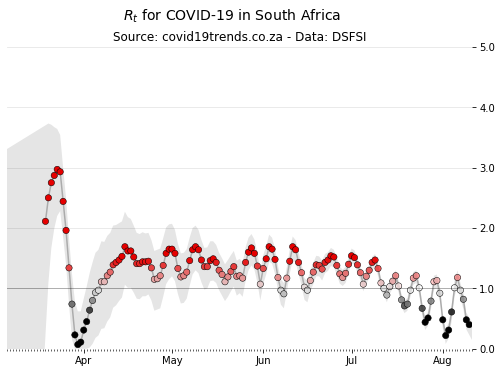

In [118]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [119]:
states_rt_i = states_all_rt_i.loc[state_filter]

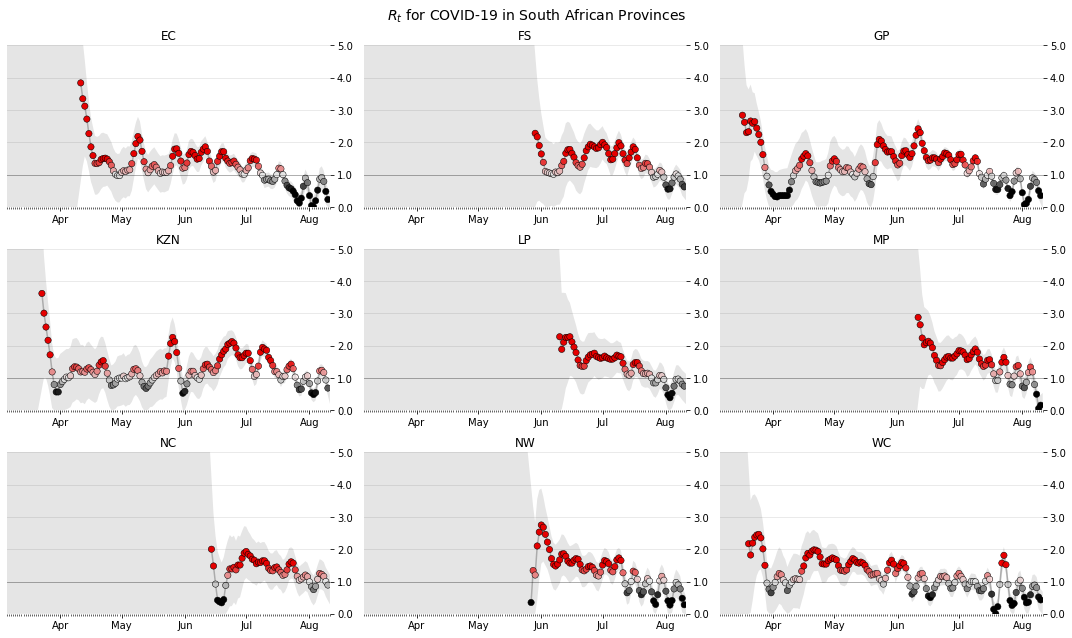

In [120]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [121]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [122]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,0.23,0.57,0.00
FS,0.62,0.91,0.27
GP,0.35,0.58,0.10
KZN,0.69,0.88,0.46
LP,0.75,1.18,0.25
MP,0.16,0.48,0.00
NC,0.89,1.32,0.41
NW,0.28,0.68,0.00
Total RSA,0.40,0.52,0.23


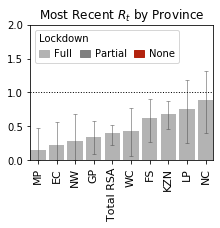

In [123]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

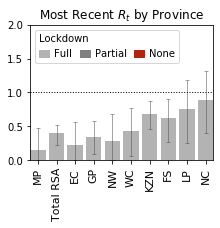

In [124]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

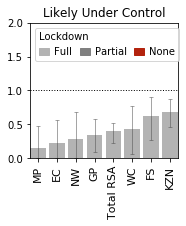

In [125]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

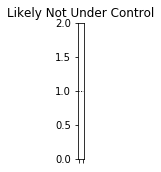

In [126]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()